In [200]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [201]:
from Functions import Cleaning_Functions
fun = Cleaning_Functions()

In [202]:
#written by Christina
def standarize_data(df):
    """
    Input: a dataset
    action: returns numeric column values scaled by mean and standard deviation
    """
    numeric_data = df.select_dtypes(include=['float64', 'int64'])
    for i in numeric_data.columns:
        df[i] = (df[i] - df[i].mean())/df[i].std()
    return df

In [203]:
def get_dummyXs_y(df, y_var):
    
    y = df[y_var]
    X  = df.drop(y_var, axis = 1)
    X_cat = X.select_dtypes(include = ["category", "O"])
    X_num = X.select_dtypes(include=['float64', 'int64'])
    
    X_cat_dummy = pd.get_dummies(X_cat)
    newX = pd.concat([X_num, X_cat_dummy], axis = 1)
    
    return newX, y

In [368]:
clean = pd.read_csv("../data/clean.csv")

In [369]:
clean.head()

,crop_count,crop_name_1,crop_harvest_1,crop_intercrop_1,ID_PROJ,ID_COUNTRY,YEAR,SURVEY_ID,ID_HH,Country,...,value_livestock_production_USD_PPP_pHH_Yr,value_livestock_prod_consumed_USD_PPP_pHH_Yr,Market_Orientation,Livestock_Orientation,Food_Availability_kCal_MAE_day,Food_Self_Sufficiency_kCal_MAE_day,NrofMonthsWildFoodCons,Gender_MaleControl,Gender_FemaleControl,continent
0,NaN,groundnut,NaN,NaN,CFM,TZ,2015,TZ_CFM_2015,TZ_2015_CFM_1_1,Tanzania,...,38.500640,0.000000,1.000000,0.049505,3650.565755,0.000000,0,0.000000,1.000000,africa
1,NaN,millet,NaN,NaN,CFM,TZ,2015,TZ_CFM_2015,TZ_2015_CFM_2_1,Tanzania,...,0.000000,0.000000,1.000000,0.000000,3632.448997,0.000000,4,0.499999,0.500001,africa
2,NaN,groundnut,NaN,NaN,CFM,TZ,2015,TZ_CFM_2015,TZ_2015_CFM_3_1,Tanzania,...,128.335467,0.000000,1.000000,0.129870,5314.779021,1750.000000,1,1.000000,0.000000,africa
3,NaN,cowpea,NaN,NaN,CFM,TZ,2015,TZ_CFM_2015,TZ_2015_CFM_4_1,Tanzania,...,0.000000,0.000000,NaN,NaN,257.234727,257.234727,0,NaN,NaN,africa
4,NaN,sesame,NaN,NaN,CFM,TZ,2015,TZ_CFM_2015,TZ_2015_CFM_5_1,Tanzania,...,233.994961,23.102694,0.931377,0.695041,925.310354,22.070240,0,1.000000,0.000000,africa


## Ridge regre y = market orientation

In [570]:
market_data = fun.delete_id_columns(clean) #1
market_data, pred_market = fun.drop_response_rows_with_NAs(market_data, "Market_Orientation", "PPI_Likelihood") #2
market_data = fun.replace_NAN_with_na(market_data) #3
market_data = fun.entry_to_lowercase(market_data) #4
market_data = fun.remove_underscores_spaces(market_data) #5
market_data = fun.convert_to_categorical(market_data) #6
market_data = fun.impute_data(market_data)

In [393]:
market_data.YEAR = market_data.YEAR.astype('category')

In [394]:
market_data = standarize_data(market_data)

In [397]:
market_data = market_data.drop("continent", axis = 1)

In [398]:
market_data.shape

(9493, 38)

In [375]:
### 1. create dummy
X_market = get_dummyXs_y(market_data, "Market_Orientation")[0]
y_market = get_dummyXs_y(market_data, "Market_Orientation")[1]

In [376]:
X_train_mo, X_test_mo, y_train_mo, y_test_mo = train_test_split(X_market,y_market, test_size = 0.3, random_state = 2021)


In [257]:
alpha_set = np.arange(150,570,2)
ridge_cv=RidgeCV(alphas=alpha_set, store_cv_values = True, fit_intercept = False)
model_cv=ridge_cv.fit(X_train,y_train)
model_cv.alpha_

456

In [258]:
cv_per_alpha = np.mean(model_cv.cv_values_, axis = 0)

In [259]:
cv_df = pd.DataFrame({'alpha': alpha_set, 'MSPE': cv_per_alpha})

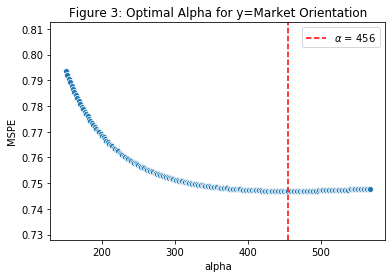

In [260]:
sns.scatterplot(data = cv_df, x = "alpha", y = "MSPE").set_title('Figure 3: Optimal Alpha for y=Market Orientation')
plt.axvline(x=model_cv.alpha_, c="red", linestyle = "dashed", label = r'$\alpha$ = 456')
plt.legend(loc='upper right')
#plt.text(458,0.80,'a=456',rotation=90)

In [261]:
#refit model with alpha =3 and get score
rir = Ridge(alpha = model_cv.alpha_)
rir.fit(X_train,y_train)
y_pred_ridge = rir.predict(X_test)
MSE_market = mean_squared_error(y_test,y_pred_ridge)
MSE_market

0.7103787262384327

In [262]:
rir.coef_

array([-1.21975909e-02, -1.50422747e-02, -1.19065942e-02, -1.25773227e-02,
        6.37022564e-03, -1.81696354e-01, -2.62713186e-02,  1.42934728e-02,
       -4.88146316e-03,  1.88159927e-03, -3.78866993e-02, -4.16752035e-02,
       -4.44745395e-02, -8.87113270e-03,  7.87830966e-03, -3.64225894e-03,
        1.44365469e-02,  1.33480079e-02,  1.43745001e-02,  1.35441738e-02,
       -5.78082214e-02,  7.97317719e-03, -1.01915484e-02, -1.48015163e-02,
       -3.25821204e-03, -3.93054048e-03,  3.29778038e-02, -7.12076405e-02,
        7.12076405e-02, -8.71031893e-03,  6.58749207e-03,  2.40493313e-03,
       -2.57599474e-02, -3.46784992e-02,  5.45415469e-03, -1.95516051e-02,
        5.57200576e-02, -4.50310331e-02,  4.21220395e-04,  3.24352358e-03,
       -3.39340119e-03, -4.09789310e-02,  0.00000000e+00, -1.67459385e-03,
        8.06875149e-03,  1.30399596e-03,  2.47330206e-03,  2.00711116e-02,
        7.77077625e-04, -7.69546883e-03, -1.35725839e-03, -2.77698115e-03,
        1.38470556e-03,  

In [263]:
betas = rir.coef_
max5_index = [list(abs(betas)).index(x) for x in np.sort(abs(betas))[::-1][:20]]
min5_index = [list(abs(betas)).index(x) for x in np.sort(abs(betas))[:5]]

In [264]:
betas[max5_index]

array([-0.43193664, -0.24813119, -0.22445284,  0.18905801, -0.18169635,
        0.14580237, -0.11601238,  0.10727208, -0.09266071,  0.09038462,
        0.09023298,  0.08058608,  0.08000519,  0.0799101 ,  0.0785681 ,
       -0.0756731 ,  0.0738416 ,  0.07263208,  0.07120764, -0.07120764])

In [265]:
betas[min5_index]

array([0.        , 0.        , 0.        , 0.        , 0.00011295])

In [266]:
X_train.columns[max5_index]

Index(['Country_tanzania', 'Country_kenya', 'YEAR_2017', 'Country_burkinafaso',
       'LivestockHoldings', 'Country_mali', 'Country_laopdr',
       'crop_name_1_greengram', 'HouseholdType_womansingle', 'YEAR_2016',
       'YEAR_2015', 'crop_harvest_1_na', 'Country_cambodia',
       'crop_intercrop_1_na', 'Country_costarica', 'crop_name_1_rice',
       'Country_drc', 'HouseholdType_couple', 'Gender_FemaleControl',
       'Gender_MaleControl'],
      dtype='object')

In [276]:
feature_imp_mo  = pd.DataFrame([X_train.columns[max5_index], betas[max5_index]]).T
feature_imp_mo.columns= ["name", "beta"] 

In [288]:
feature_imp_mo

,name,beta
0,Country_tanzania,-0.431937
1,Country_kenya,-0.248131
2,YEAR_2017,-0.224453
3,Country_burkinafaso,0.189058
4,LivestockHoldings,-0.181696
5,Country_mali,0.145802
6,Country_laopdr,-0.116012
7,crop_name_1_greengram,0.107272
8,HouseholdType_womansingle,-0.0926607
9,YEAR_2016,0.0903846


### predict y for market orientation y = Na

In [642]:
#pred_market.columns

In [572]:
#pred_market = pred_market.drop("continent", axis = 1)

In [641]:

# smallData = fun.replace_NAN_with_na(pred_market) #3
# smallData = fun.entry_to_lowercase(smallData) #4
# smallData = fun.remove_underscores_spaces(smallData) #5
# smallData = fun.convert_to_categorical(smallData) #6
# smallData = fun.impute_data(smallData)
# smallData

In [643]:
# smallData.columns

In [640]:
#smallData.dtypes

In [629]:
# smallData.YEAR = smallData.YEAR.astype('category')
# std_data = standarize_data(smallData)

# std_data = std_data.reset_index(drop = True)

In [620]:
#std_data = std_data.drop("Market_Orientation",axis = 1)


In [644]:
# isNA = []
# sumNA = []
# for i in std_data.columns:
#     isNA.append(i)
#     a = std_data[i].isna().sum()
#     sumNA.append(a)


In [645]:
# inf = pd.DataFrame([isNA, sumNA]).T
# inf.columns = ["a","b"]
# inf

In [634]:
# #impute
# for i in inf[21:33].a:
#     std_data[i] = std_data[i].fillna(np.nanmedian(market_data[i]))

In [646]:
# data_pt = std_data.iloc[[0]]
# data_pt

# Ridge regression with y=PPI_Likelihood

In [289]:
clean.head(4)

,crop_count,crop_name_1,crop_harvest_1,crop_intercrop_1,ID_PROJ,ID_COUNTRY,YEAR,SURVEY_ID,ID_HH,Country,...,value_livestock_production_USD_PPP_pHH_Yr,value_livestock_prod_consumed_USD_PPP_pHH_Yr,Market_Orientation,Livestock_Orientation,Food_Availability_kCal_MAE_day,Food_Self_Sufficiency_kCal_MAE_day,NrofMonthsWildFoodCons,Gender_MaleControl,Gender_FemaleControl,continent
0,NaN,groundnut,NaN,NaN,CFM,TZ,2015,TZ_CFM_2015,TZ_2015_CFM_1_1,Tanzania,...,38.500640,0.0,1.0,0.049505,3650.565755,0.000000,0,0.000000,1.000000,africa
1,NaN,millet,NaN,NaN,CFM,TZ,2015,TZ_CFM_2015,TZ_2015_CFM_2_1,Tanzania,...,0.000000,0.0,1.0,0.000000,3632.448997,0.000000,4,0.499999,0.500001,africa
2,NaN,groundnut,NaN,NaN,CFM,TZ,2015,TZ_CFM_2015,TZ_2015_CFM_3_1,Tanzania,...,128.335467,0.0,1.0,0.129870,5314.779021,1750.000000,1,1.000000,0.000000,africa
3,NaN,cowpea,NaN,NaN,CFM,TZ,2015,TZ_CFM_2015,TZ_2015_CFM_4_1,Tanzania,...,0.000000,0.0,NaN,NaN,257.234727,257.234727,0,NaN,NaN,africa


In [290]:
ppi_data = fun.delete_id_columns(clean) #1
ppi_data, pred_market = fun.drop_response_rows_with_NAs(ppi_data,"PPI_Likelihood" ,"Market_Orientation") #2
ppi_data = fun.replace_NAN_with_na(ppi_data) #3
ppi_data = fun.entry_to_lowercase(ppi_data) #4
ppi_data = fun.remove_underscores_spaces(ppi_data) #5
ppi_data = fun.convert_to_categorical(ppi_data) #6
ppi_data = fun.impute_data(ppi_data)#7

In [291]:
ppi_data.head(3)

,crop_count,crop_name_1,crop_harvest_1,crop_intercrop_1,YEAR,Country,HHsizemembers,HHsizeMAE,HouseholdType,Head_EducationLevel,...,value_crop_consumed_USD_PPP_pHH_Yr,livestock_prodsales_USD_PPP_pHH_Yr,value_livestock_production_USD_PPP_pHH_Yr,value_livestock_prod_consumed_USD_PPP_pHH_Yr,Food_Availability_kCal_MAE_day,Food_Self_Sufficiency_kCal_MAE_day,NrofMonthsWildFoodCons,Gender_MaleControl,Gender_FemaleControl,continent
0,2.0,groundnut,na,na,2015,tanzania,4,3.32,single,primary,...,0.0,38.500640,38.500640,0.0,3650.565755,0.0,0,0.000000,1.000000,africa
1,2.0,millet,na,na,2015,tanzania,10,5.85,together,primary,...,0.0,0.000000,0.000000,0.0,3632.448997,0.0,4,0.499999,0.500001,africa
2,2.0,groundnut,na,na,2015,tanzania,5,4.32,together,illiterate,...,0.0,128.335467,128.335467,0.0,5314.779021,1750.0,1,1.000000,0.000000,africa


In [292]:
ppi_data = ppi_data.drop("Country", axis = 1)
ppi_data.YEAR = ppi_data.YEAR.astype('category')
ppi_data = standarize_data(ppi_data)

In [314]:
ppi_data.head()

,crop_count,crop_name_1,crop_harvest_1,crop_intercrop_1,YEAR,HHsizemembers,HHsizeMAE,HouseholdType,Head_EducationLevel,LandOwned,...,value_crop_consumed_USD_PPP_pHH_Yr,livestock_prodsales_USD_PPP_pHH_Yr,value_livestock_production_USD_PPP_pHH_Yr,value_livestock_prod_consumed_USD_PPP_pHH_Yr,Food_Availability_kCal_MAE_day,Food_Self_Sufficiency_kCal_MAE_day,NrofMonthsWildFoodCons,Gender_MaleControl,Gender_FemaleControl,continent
0,-0.244425,groundnut,na,na,2015,-0.503310,-0.462416,single,primary,-0.055997,...,-0.029505,-0.019880,-0.019415,-0.012311,-0.017661,-0.036510,-0.563701,-2.620626,2.620626,africa
1,-0.244425,millet,na,na,2015,0.241895,-0.057205,together,primary,-0.055997,...,-0.029505,-0.020955,-0.019858,-0.012311,-0.017662,-0.036510,0.962623,-0.995541,0.995541,africa
2,-0.244425,groundnut,na,na,2015,-0.379110,-0.302253,together,illiterate,-0.055997,...,-0.029505,-0.017373,-0.018381,-0.012311,-0.017544,-0.026575,-0.182120,0.629550,-0.629550,africa
3,-0.244425,cowpea,na,na,2015,0.366095,0.500161,together,primary,-0.055997,...,-0.029505,-0.020955,-0.019858,-0.012311,-0.017899,-0.035050,-0.563701,0.629550,-0.629550,africa
4,-0.244425,sesame,na,na,2015,-0.254909,-0.127676,together,secondary,-0.055997,...,-0.029505,-0.015069,-0.017165,-0.012019,-0.017852,-0.036385,-0.563701,0.629550,-0.629550,africa


In [293]:
X_ppi = get_dummyXs_y(ppi_data, "PPI_Likelihood")[0]
y_ppi = get_dummyXs_y(ppi_data, "PPI_Likelihood")[1]

In [294]:
X_train_ppi, X_test_ppi, y_train_ppi, y_test_ppi = train_test_split(X_ppi ,y_ppi, test_size = 0.3, 
                                                                    random_state = 2021)


In [295]:
alpha_set = np.arange(10,70,1)
ridge_cv_ppi=RidgeCV(alphas=alpha_set, store_cv_values = True, fit_intercept = False)
model_ppi_cv=ridge_cv_ppi.fit(X_train_ppi,y_train_ppi)
model_ppi_cv.alpha_

29

In [296]:
ppi_cv_per_alpha = np.mean(model_ppi_cv.cv_values_, axis = 0)
ppi_cv_df = pd.DataFrame({'alpha': alpha_set, 'MSPE': ppi_cv_per_alpha})

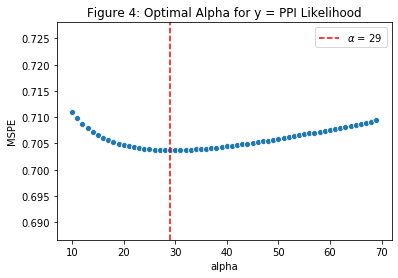

In [299]:
sns.scatterplot(data = ppi_cv_df, x = "alpha", y = "MSPE", ax=ax1).set_title('Figure 4: Optimal Alpha for y = PPI Likelihood')
plt.axvline(x=29, c="red", linestyle = "dashed",label = r'$\alpha$ = 29' )
plt.legend(loc='upper right')

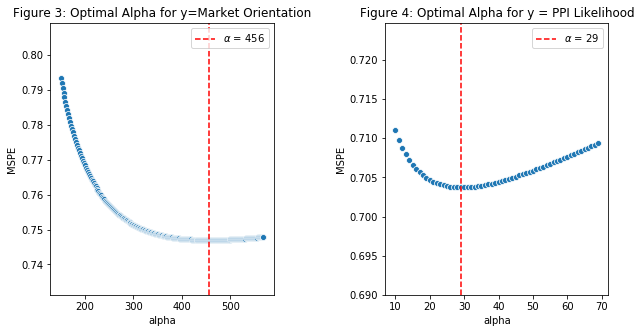

In [306]:
# Two subplots
fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(wspace=.5)

sns.scatterplot(ax = axes[0],data = cv_df, x = "alpha", y = "MSPE")
axes[0].set_title('Figure 3: Optimal Alpha for y=Market Orientation')
axes[0].axvline(x=model_cv.alpha_, c="red", linestyle = "dashed", label = r'$\alpha$ = 456')
axes[0].legend(loc='upper right')


sns.scatterplot(ax = axes[1], data = ppi_cv_df, x = "alpha", y = "MSPE")
axes[1].set_title('Figure 4: Optimal Alpha for y = PPI Likelihood')
axes[1].axvline(x=29, c="red", linestyle = "dashed",label = r'$\alpha$ = 29' )
axes[1].legend(loc='upper right')

In [307]:
#refit model with alpha =3 and get score
ridge_ppi = Ridge(alpha = model_ppi_cv.alpha_)
ridge_ppi.fit(X_train_ppi,y_train_ppi)
y_pred_ridge_ppi = ridge_ppi.predict(X_test_ppi)
MSE_ppi = np.mean((y_pred_ridge_ppi-np.array(y_test_ppi))**2)
MSE_ppi

0.8450827169299572

In [308]:
#top 20 coeff/variable that are most important by abs value
betas_ppi = ridge_ppi.coef_
max5_index_ppi = [list(abs(betas_ppi)).index(x) for x in np.sort(abs(betas_ppi))[::-1][:20]]
min5_index_ppi = [list(abs(betas_ppi)).index(x) for x in np.sort(abs(betas_ppi))[:5]]

In [309]:
betas_ppi[max5_index_ppi]

array([-0.93587502, -0.80216631,  0.67557116,  0.50447549,  0.49444495,
       -0.48875491, -0.43346478,  0.37808512, -0.37639515, -0.3340159 ,
       -0.29992202, -0.25178839,  0.24999531,  0.24609834, -0.2059205 ,
        0.20259967, -0.19798459, -0.19627443, -0.18747561,  0.17995231])

In [310]:
betas_ppi[min5_index_ppi]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.48610165e-05])

In [311]:
X_train_ppi.columns[max5_index_ppi]

Index(['continent_centralamerica', 'Head_EducationLevel_none',
       'continent_africa', 'Head_EducationLevel_noschool', 'YEAR_2015',
       'YEAR_2018', 'crop_name_1_irishpotato', 'HHsizemembers',
       'crop_name_1_teff', 'crop_name_1_wheat', 'HHsizeMAE', 'YEAR_2016',
       'continent_asia', 'YEAR_2017', 'HouseholdType_single',
       'Head_EducationLevel_primary', 'crop_name_1_rice',
       'HouseholdType_together', 'livestock_prodsales_USD_PPP_pHH_Yr',
       'crop_name_1_pigeonpea'],
      dtype='object')

In [313]:
feature_imp_ppi  = pd.DataFrame([X_train_ppi.columns[max5_index_ppi], betas_ppi[max5_index_ppi]]).T
feature_imp_ppi.columns = ["name", "beta"]
feature_imp_ppi

,name,beta
0,continent_centralamerica,-0.935875
1,Head_EducationLevel_none,-0.802166
2,continent_africa,0.675571
3,Head_EducationLevel_noschool,0.504475
4,YEAR_2015,0.494445
5,YEAR_2018,-0.488755
6,crop_name_1_irishpotato,-0.433465
7,HHsizemembers,0.378085
8,crop_name_1_teff,-0.376395
9,crop_name_1_wheat,-0.334016


In [ ]:
all_together = pd.concat([feature_imp_ppi, feature_imp_mo],axis = 1)
all_together